In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import copy
import numpy as np
import re
import nltk
from sklearn.datasets import load_files
nltk.download('stopwords')
nltk.download('wordnet')
import pickle
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:



review_data = load_files(r"/content/gdrive/My Drive/movie_review/movie_review")
X, y = review_data.data, review_data.target

documents = []

stemmer = WordNetLemmatizer()

for sen in range(0, len(X)):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X[sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)

vectorizer = CountVectorizer(max_features=2000, min_df=50, max_df=0.7, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(documents).toarray()

tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)


In [9]:

class MLP(object):
    
    @staticmethod
    def sigmoid(x):
        return 1/(1+np.power(np.e, -x))

    @staticmethod
    def identity(x):
        return x

    @staticmethod
    def inv_sig(x):
        tmp = MLP.sigmoid(x)
        return tmp*(1-tmp)



    def __init__(self, **kwargs):


        self.layers = kwargs['layers']
        self.activate = [MLP.identity]
        self.weights = [1]
        self.lr = 0.0001
        self.lam = 0.00001

        for i in range(1, len(self.layers)):
          if (i == 1):
            self.weights.append(np.random.normal(0, 1, (self.layers[i-1],self.layers[i])))
          elif (i == len(self.layers)-1):
            self.weights.append(np.random.normal(0, 1, (self.layers[i-1]+1,self.layers[i])))
          else:
            self.weights.append(np.random.normal(0, 1, (self.layers[i-1]+1,self.layers[i])))

        self.weights_e = []
        for i in range(1, len(self.weights[1:len(self.weights)])):
          for j in self.weights[i]:
            for k in j:
              self.weights_e.append(k)
        self.weights_e = np.array(self.weights_e)

       
  
    def feed_forward(self, xs):

        self.U = [xs]
        z = []

        for i in range(1, len(self.layers)):
            u = self.U[i-1].dot(self.weights[i])
            u = MLP.sigmoid(u)
            u = u.tolist()
            for i in u:
              if len(i) is not 1:
                i.insert(0,1.0)
            u = np.array(u)
            self.U.append(u)
        
        for i in range(len(self.U[-1])):
          np.delete([1],self.U[-1][i])
        return self.U[-1]


    def back_propagate(self, xs, ys):

        pred_ys = self.feed_forward(xs)
        self.D = []

        for i in reversed(range(1,len(self.layers))):
            if i == len(self.layers) - 1:
                d = pred_ys - ys
            else:
                d = self.inv_sig(self.U[i])*(self.D[-1].dot(self.weights[i+1].T))


            dW = self.U[i-1].T.dot(d)
            if (np.shape(dW)) != (np.shape(self.weights[i])):
                dW = dW.T
                dW = dW[1:len(dW)]
                dW = dW.T
            
            self.weights[i] -= self.lr*(dW + self.lam * self.weights[i])
            if np.shape(d)[1] is not 1:
                d = d.T
                d = d[1:len(d)]
                d= d.T
            self.D.append(d)
        return

    def evaluate(self, xs, ys):
        pred_ys = self.feed_forward(xs)
        pred_ys_e = pred_ys.flatten()
        ys_e = ys.flatten()
        
        loss = np.mean(-ys_e * np.log(pred_ys_e) - (1 - ys_e) * np.log(1 - pred_ys_e)) + self.lam/2 * np.mean(self.weights_e*self.weights_e)
        return loss

    def get_accuracy(self, xs, ys):
        pred_ys = self.feed_forward(xs)
        count = 0
        for i in range(len(pred_ys)):
          if pred_ys[i][0] >= 0.5:
            if ys[i][0] == 1:
              count += 1
          else:
            if ys[i][0] == 0:
              count += 1
        return count
    

if __name__ == '__main__':
    
    model = MLP(layers=[2000, 500, 150, 50, 10, 1])
    train_label = []
    test_label = []
    for i in range(len(X_train)):
      train_label.append([y_train[i]])
    for i in range(len(X_test)):
      test_label.append([y_test[i]])
    xs = np.array(X_train)
    ys = np.array(train_label)
    xs_t = np.array(X_test)
    ys_t = np.array(test_label)


    pred_ys = model.feed_forward(xs)
    loss_h_tr = []
    loss_h_t = []
    acc_h_tr = []
    acc_h_t = []
    for i in range(7000):
        model.back_propagate(xs, ys)
        loss_h_tr.append(copy.deepcopy(model.evaluate(xs, ys)))
        loss_h_t.append(copy.deepcopy(model.evaluate(xs_t, ys_t)))
        acc_h_tr.append(copy.deepcopy(model.get_accuracy(xs, ys)))
        acc_h_t.append(copy.deepcopy(model.get_accuracy(xs_t, ys_t)))

        if (i+1) % 500 == 0:
            error = model.evaluate(xs, ys)
            print('ITER={:05d}, RMSE={:.4f}'.format(i+1, error))
            
    y_pred_train = model.feed_forward(xs)
    y_pred_test = model.feed_forward(xs_t)
    
    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


ITER=00500, RMSE=0.3462
ITER=01000, RMSE=0.1840
ITER=01500, RMSE=0.0046
ITER=02000, RMSE=0.0022
ITER=02500, RMSE=0.0038
ITER=03000, RMSE=0.0012
ITER=03500, RMSE=0.0016
ITER=04000, RMSE=0.0021
ITER=04500, RMSE=0.0007
ITER=05000, RMSE=0.0007
ITER=05500, RMSE=0.0007
ITER=06000, RMSE=0.0007
ITER=06500, RMSE=0.0007
ITER=07000, RMSE=0.0007


In [5]:
    y_pred_train = model.feed_forward(xs)
    y_pred_test = model.feed_forward(xs_t)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


#1. Plot the loss curve

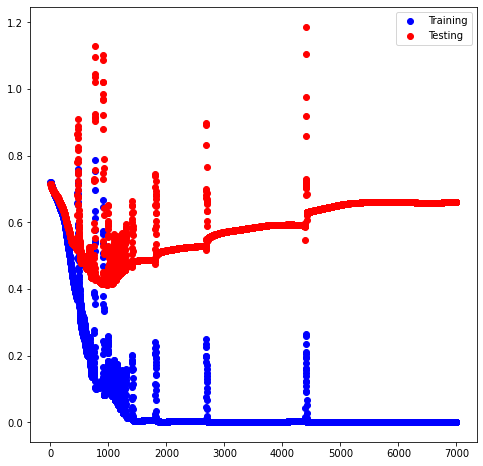

In [10]:
plt.figure(figsize=(8, 8))
plt.scatter(range(len(loss_h_tr)), loss_h_tr, c='blue', label = "Training")
plt.scatter(range(len(loss_h_t)), loss_h_t, c='red', label = "Testing")
plt.legend(loc='upper right')
plt.show()





















#2. Plot the training accuracy

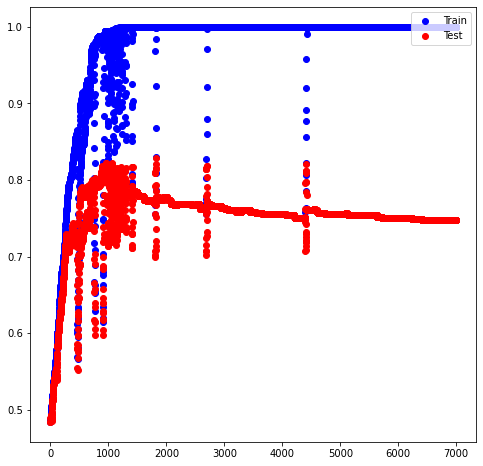

In [11]:
#Plot the training accuracy

acc_r_tr = []
acc_r_t = []
for i in acc_h_tr:
  acc_r_tr.append(copy.deepcopy(i/len(X_train)))
for i in acc_h_t:
  acc_r_t.append(copy.deepcopy(i/len(X_test)))



plt.figure(figsize=(8, 8))
plt.scatter(range(len(acc_r_tr)),  acc_r_tr, c='blue', label = "Train")
plt.scatter(range(len(acc_r_t)),  acc_r_t, c='red', label = "Test")

plt.legend(loc='upper right')
plt.show()














#3.  Plot the quantitative results

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
y_p_test = []
y_p_train = []
y_pred_train = y_pred_train.flatten()
y_pred_test = y_pred_test.flatten()
for i in y_pred_test:
  if i >= 0.5:
    y_p_test.append(1)
  else:
    y_p_test.append(0)
for i in y_pred_train:
  if i >= 0.5:
    y_p_train.append(1)
  else:
    y_p_train.append(0)



print(confusion_matrix(y_train,y_p_train))
print(classification_report(y_train,y_p_train))
print(accuracy_score(y_train, y_p_train))

print(confusion_matrix(y_test,y_p_test))
print(classification_report(y_test,y_p_test))
print(accuracy_score(y_test, y_p_test))


















[[699   0]
 [  0 702]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       699
           1       1.00      1.00      1.00       702

    accuracy                           1.00      1401
   macro avg       1.00      1.00      1.00      1401
weighted avg       1.00      1.00      1.00      1401

1.0
[[155 147]
 [  5 294]]
              precision    recall  f1-score   support

           0       0.97      0.51      0.67       302
           1       0.67      0.98      0.79       299

    accuracy                           0.75       601
   macro avg       0.82      0.75      0.73       601
weighted avg       0.82      0.75      0.73       601

0.7470881863560732


#4. Final training accuracy

In [13]:
#Write down the final training accuracy
print(acc_r_tr[len(acc_r_tr)-1])
print(acc_r_t[len(acc_r_t)-1])







1.0
0.7470881863560732
